# Exploring NASA POWER Data with Machine Learning
Author: Elizabeth Thompson  
DAT431 Project 1  


## Introduction

This project explores how machine learning can be applied to climate data temperature prediction. Using daily records from the **NASA POWER Project** (AWS Open Data), I analyze features such as wind speed, humidity, solar radiation, and precipitation to model average temperature. 

**Two methods are compared:**    
-Linear Regreassion with Regularization   
-k_Nearest Neighbors (kNN)

I also highlight the **bias-variance tradeoff** by tuning model parameters and observing how complexity affects performance. The goal is to connect theory with practice while gaining insight into real world climate data.

## Libraries

I used Python libraries that cover data access, analysis, visualization, and modeling:

- **pandas** and **numpy**: the core tools for managing structured data and performing fast numerical operations.  
- **matplotlib.pyplot** and **seaborn**: used to build visualizations, with seaborn enhancing matplotlib for clearer, more polished plots.  
- **scikit-learn**: provides machine learning methods.
- **requests**: enables direct communication with the NASA POWER API to retrieve daily climate data for analysis.



In [88]:
# Data handling
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

# For API call
import requests

sns.set(style="whitegrid", font_scale=1.2)


## Dataset
The dataset comes from the **NASA POWER Project**, which provides 
satellite-based weather and climate variables.  
I selected data for Phoenix, AZ, including:
- Temperature (target)
- Wind speed
- Humidity
- Solar radiation
- Precipitation


In [91]:
url = ("https://power.larc.nasa.gov/api/temporal/daily/point"
       "?parameters=T2M,WS2M,QV2M,ALLSKY_SFC_SW_DWN,PRECTOTCORR"
       "&community=RE"
       "&longitude=-112.07&latitude=33.45"
       "&start=20100101&end=20201231"
       "&format=CSV")

response = requests.get(url)
with open("nasa_power_phoenix.csv", "wb") as f:
    f.write(response.content)


## Load and Prepare the Data

The NASA POWER dataset includes both a **metadata header** and the actual daily weather measurements.  
Before we can work with the data, we need to:

1. **Locate the end of the metadata header** (`-END HEADER-`).  
2. **Load the CSV starting just after the header** to get only the real data.  
3. **Inspect the column names** and rename key variables for clarity.  
4. **Create a Date column** that can be used for plotting and modeling.  

This block ensures that the dataset is cleanly loaded and structured for analysis and machine learning.


In [104]:
# Find where -END HEADER- is
with open("nasa_power_phoenix.csv") as f:
    lines = f.readlines()
    
header_line = 0
for i, line in enumerate(lines):
    if "-END HEADER-" in line:
        header_line = i
        break

df = df.rename(columns={
    "T2M": "Temp",
    "WS2M": "Wind",
    "QV2M": "Humidity",
    "ALLSKY_SFC_SW_DWN": "Solar",
    "PRECTOTCORR": "Precip"
})

# Create a Date column
if "YYYYMMDD" in df.columns:
    df["Date"] = pd.to_datetime(df["YYYYMMDD"], format="%Y%m%d")
elif {"YEAR", "MO", "DY"}.issubset(df.columns):
    df["Date"] = pd.to_datetime(df[["YEAR", "MO", "DY"]].astype(str).agg("-".join, axis=1))
elif {"YEAR", "MO"}.issubset(df.columns):
    df["Date"] = pd.to_datetime(df["YEAR"].astype(str) + "-" + df["MO"].astype(str) + "-01")
elif "YEAR" in df.columns:
    df["Date"] = pd.to_datetime(df["YEAR"].astype(str))
else:
    raise ValueError("No usable date information found in dataset!")

# Drop rows with missing values
df = df.dropna()

# Convert all feature columns to numeric if possible
numeric_cols = ["Temp", "Wind", "Humidity", "Solar", "Precip"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Correct impossible values
if "Precip" in df.columns:
    df["Precip"] = df["Precip"].clip(lower=0)  # no negative precipitation

# Define target and features
target = "Temp"
features = [c for c in df.columns if c not in ["Date", target, "YEAR", "MO", "DY", "YYYYMMDD"]]

# Preview cleaned data
print("Columns:", df.columns.tolist())
print(df.head())

Columns: ['YEAR', 'MO', 'DY', 'Temp', 'Wind', 'Humidity', 'Solar', 'Precip', 'Date']
   YEAR  MO  DY   Temp  Wind  Humidity   Solar  Precip       Date
0  2010   1   1  10.21  2.62      2.44  3.5258    0.00 2010-01-01
1  2010   1   2  12.57  1.53      3.31  3.6518    0.01 2010-01-02
2  2010   1   3  11.21  2.58      3.04  3.6874    0.00 2010-01-03
3  2010   1   4  12.13  2.99      2.96  3.4255    0.00 2010-01-04
4  2010   1   5  13.04  1.75      3.08  3.7282    0.00 2010-01-05


### Data Splitting & Scaling

Before training any machine learning models, we need to **separate the data into training and test sets**.  
- The **training set** is used to fit the model, while the **test set** evaluates its performance on unseen data.  
- We also **standardize the features** so that all variables are on a similar scale.

In [107]:
X = df[features].values
y = df[target].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

# Standardize predictors
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


## Methods

We aim to predict daily temperature in Phoenix using several weather features and explore model behavior under different settings.

### k-Nearest Neighbors
We experiment with **k = 1–50 neighbors** to see how model complexity affects performance.  
RMSE is calculated for both training and test sets to reveal the **bias–variance tradeoff**:  
- Small k → captures noise (low bias, high variance)  
- Large k → oversmooths (high bias, low variance)

### Ridge & Lasso Regression
Ridge (L2) and Lasso (L1) regression add penalties to reduce overfitting.  
We tune **alpha** values and track test RMSE to examine bias–variance patterns.  

### Lasso Feature Selection
The best Lasso model highlights the most influential features by shrinking less important coefficients to zero, providing a **data-driven feature ranking**.


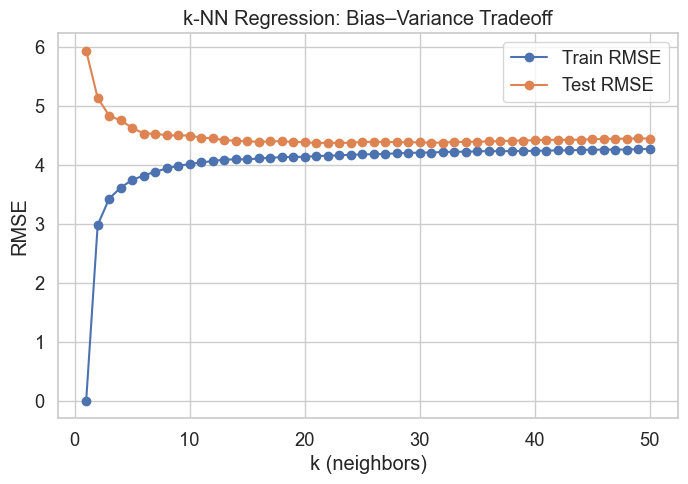

In [110]:
k_values = range(1, 51)
train_rmse, test_rmse = [], []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_s, y_train)
    
    # Predictions
    y_pred_train = knn.predict(X_train_s)
    y_pred_test = knn.predict(X_test_s)
    
    # RMSE
    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))

# Plot
plt.figure(figsize=(8,5))
plt.plot(k_values, train_rmse, label="Train RMSE", marker="o")
plt.plot(k_values, test_rmse, label="Test RMSE", marker="o")
plt.xlabel("k (neighbors)")
plt.ylabel("RMSE")
plt.title("k-NN Regression: Bias–Variance Tradeoff")
plt.legend()
plt.show()


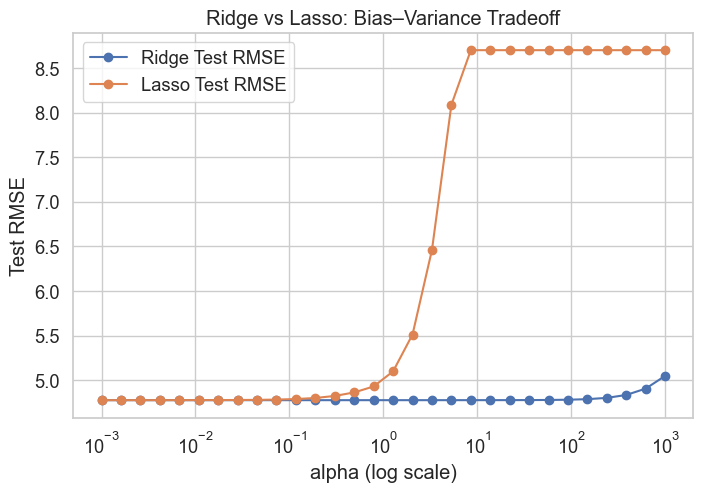

In [111]:
alphas = np.logspace(-3, 3, 30)
ridge_rmse, lasso_rmse = [], []

for a in alphas:
    # Ridge
    ridge = Ridge(alpha=a).fit(X_train_s, y_train)
    ridge_pred = ridge.predict(X_test_s)
    ridge_rmse.append(np.sqrt(mean_squared_error(y_test, ridge_pred)))
    
    # Lasso
    lasso = Lasso(alpha=a, max_iter=10000).fit(X_train_s, y_train)
    lasso_pred = lasso.predict(X_test_s)
    lasso_rmse.append(np.sqrt(mean_squared_error(y_test, lasso_pred)))

# Plot
plt.figure(figsize=(8,5))
plt.semilogx(alphas, ridge_rmse, label="Ridge Test RMSE", marker="o")
plt.semilogx(alphas, lasso_rmse, label="Lasso Test RMSE", marker="o")
plt.xlabel("alpha (log scale)")
plt.ylabel("Test RMSE")
plt.title("Ridge vs Lasso: Bias–Variance Tradeoff")
plt.legend()
plt.show()



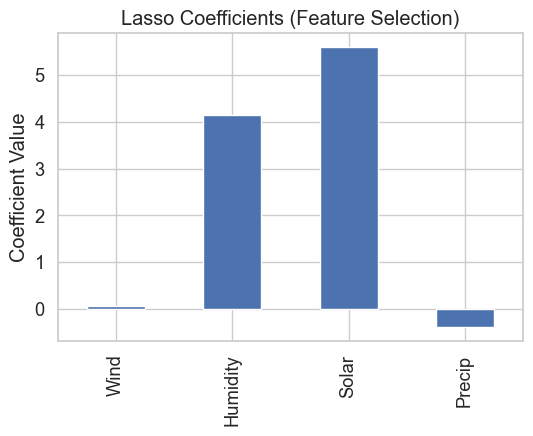

In [113]:
lasso_best = Lasso(alpha=0.1, max_iter=10000).fit(X_train_s, y_train)
coef_df = pd.Series(lasso_best.coef_, index=features)

plt.figure(figsize=(6,4))
coef_df.plot(kind="bar")
plt.title("Lasso Coefficients (Feature Selection)")
plt.ylabel("Coefficient Value")
plt.show()


## Conclusion

In this project, we explored daily temperature prediction in Phoenix using several weather features.  
We applied k-Nearest Neighbors, Ridge, and Lasso regression to analyze model performance and examine the **bias–variance tradeoff**.  

Key takeaways:  
- k-NN highlighted how the choice of neighbors affects overfitting and underfitting.  
- Ridge and Lasso demonstrated the benefits of regularization, with Lasso also performing **feature selection**.  
- Standardizing predictors was crucial for consistent model performance.  

Overall, this analysis emphasizes the importance of **data preprocessing, model tuning, and understanding bias–variance dynamics** when building predictive models on real-world datasets.

### References

1. NASA POWER Project: [https://power.larc.nasa.gov/](https://power.larc.nasa.gov/)  
2. Pedregosa, F., et al. (2011). *Scikit-learn: Machine Learning in Python*. Journal of Machine Learning Research, 12, 2825–2830.  
3. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). *An Introduction to Statistical Learning* (2nd Edition). Springer.
